# 1️⃣ Load & Preprocess Data

In [11]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
#Dataset directories
BASE_DIR = "/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/data-set/archive"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preparation and augumentation for Training
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True) # rescale=1./255 => Min-Max Scaling used to normalize the pixel values between 0 and 1

# Data preparation for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading the Training Data
train_generator = train_datagen.flow_from_directory(directory = TRAIN_DIR,target_size = IMG_SIZE, batch_size = BATCH_SIZE, class_mode ='binary') # Label encding is used above as we have two classes (Cancer and Non-Cancer)

# Load Testing Data
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
) # Label encoding is used above as we have two classes (Cancer and Non-Cancer)

# Print class labels
print("Class Mapping:", train_generator.class_indices)


Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


# 2️⃣ Exploratory Data Analysis (EDA)

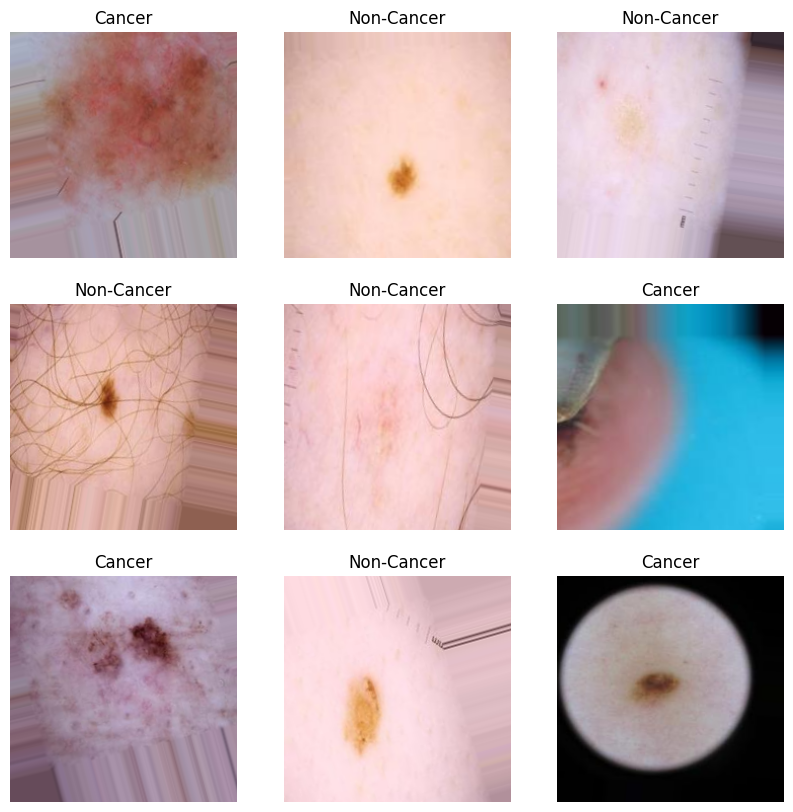

In [51]:
# Display some sample images from dataset
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i]==1 else "Non-Cancer")
        plt.axis('off')
    plt.show()

# Plot Training Images
plot_images(train_generator)

# 3️⃣ Build CNN Model

In [52]:
# Building CNN model for binary images classification

from tensorflow.keras import layers, models

model = models.Sequential([
    # !--CNN feature extraction--!
    # 1st convolutional layer block
    layers.Conv2D(32, (3, 3), activation='relu' , input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    # 2nd convolutional layer block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # 3rd convolutional layer block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    #!--CNN classification--!
    layers.Flatten(),  # flatten for classification

    # fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(1,activation='sigmoid') # Output layer for binary classification
])

# Compiling the model
model.compile(optimizer='adam', # Optimizer
              loss='binary_crossentropy', # Binnary classificationLoss
              metrics=['accuracy']) # Accuracy metric

# Model summary
model.summary()

/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/melanoma-detection-venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

# 4️⃣ Train & Evaluate Model

In [54]:
# defining early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, # Stop training after 5 epochs with no improvemen
    restore_best_weights=True,
    verbose=1)

# defining learning rate reduction
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3 , # Reduce LR if no improvement after 3 epochs
    factor=0.1, 
    min_lr=1e-7,
    verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = 30, # Set number of epochs to train the model
    validation_data = test_generator,
    validation_steps = test_generator.samples // BATCH_SIZE,
    callbacks = [early_stopping, lr_scheduler]
)

/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/melanoma-detection-venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 144s 385ms/step - accuracy: 0.7183 - loss: 0.6280 - val_accuracy: 0.7818 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 2:07 344ms/step - accuracy: 0.8125 - loss: 0.3534

/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/melanoma-detection-venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8125 - loss: 0.3534 - val_accuracy: 0.7833 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 139s 374ms/step - accuracy: 0.8053 - loss: 0.4216 - val_accuracy: 0.8221 - val_loss: 0.3738 - learning_rate: 0.0010
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7500 - loss: 0.4119 - val_accuracy: 0.8256 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 139s 374ms/step - accuracy: 0.8264 - loss: 0.3951 - val_accuracy: 0.8599 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7812 - loss: 0.4771 - val_accuracy: 0.8523 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 220s 594ms/step - accuracy: 0.8222 - loss: 0.4051 - val_accuracy: 0.8160 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 8/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 2:12 357ms/step - accuracy: 0.8750 - loss: 0

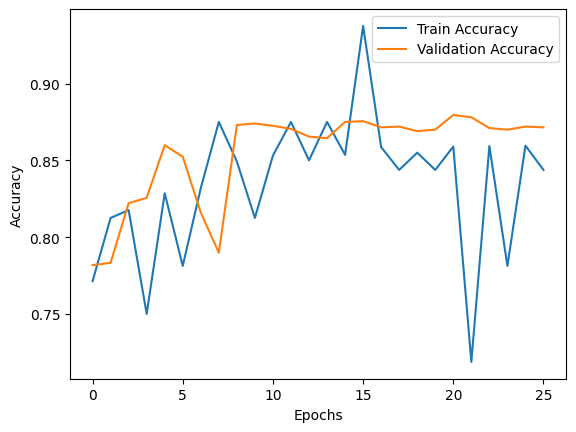

In [57]:
# Save Model
model.save("skin_cancer_cnn.keras")

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 5️⃣ Evaluate Model Performance

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1000
           1       0.49      0.47      0.48       984

    accuracy                           0.50      1984
   macro avg       0.50      0.50      0.50      1984
weighted avg       0.50      0.50      0.50      1984



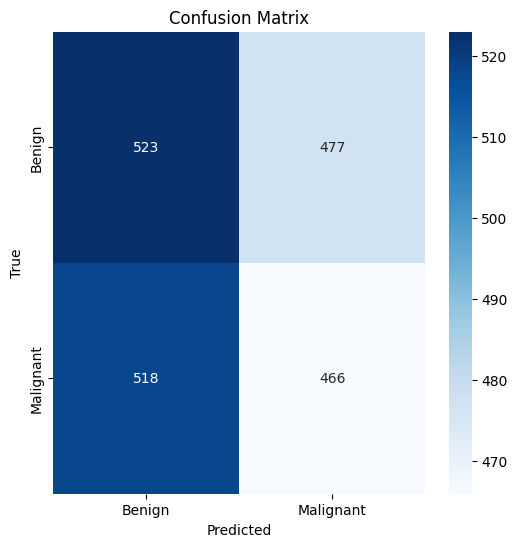

In [58]:
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 6️⃣ Prediction System

In [59]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/melanoma-detection/skin_cancer_cnn.keras')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/melanoma-detection-venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


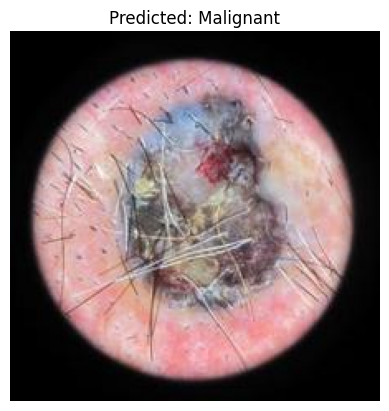

In [64]:

# Test on new image
predict_skin_cancer("/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/data-set/archive/test/Malignant/5616.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


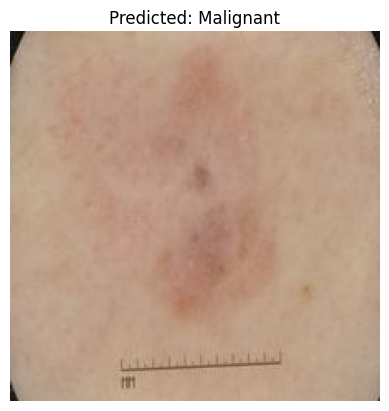

In [65]:

# Test on new image
predict_skin_cancer("/Users/ths/Library/CloudStorage/OneDrive-AmadeusWorkplace/projects/data-science/melanoma-detection/data-set/archive/train/Malignant/1004.jpg", model)